In [2]:
import numpy as np
import ripser
import persim

from matplotlib import pyplot as plt
from sklearn.decomposition import KernelPCA

In [3]:
def generate_cylinder(n_points, noise=0):
    z = np.random.rand(n_points)
    alphas = np.random.rand(n_points) * 2 * np.pi
    
    x, y = np.cos(alphas), np.sin(alphas)
    
    return np.stack((x, y, z), axis=1) + noise * np.random.randn(n_points, 3)

### For linear PCA we get the following

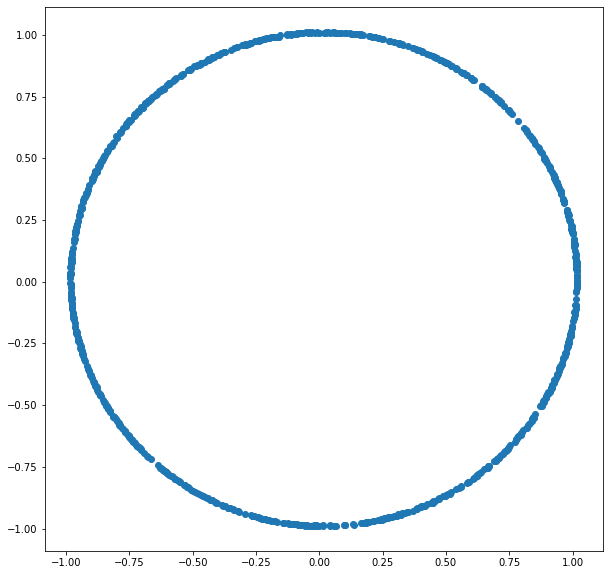

In [4]:
pca = KernelPCA(2)
points = pca.fit_transform(generate_cylinder(1000))

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1])
plt.show()

### For kernel PCA with sigmoid kernel we get this parametric family of images

Gamma = 0.1


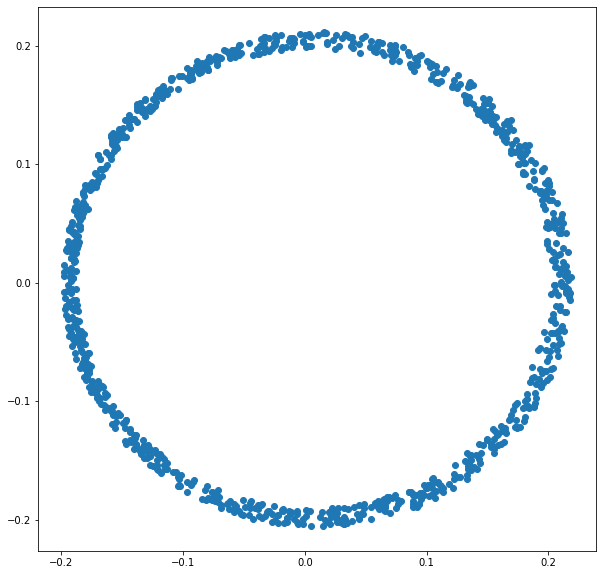

Gamma = 1


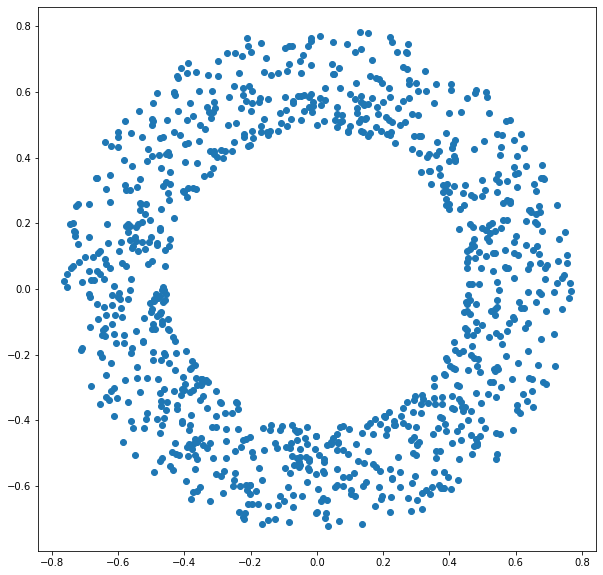

Gamma = 2


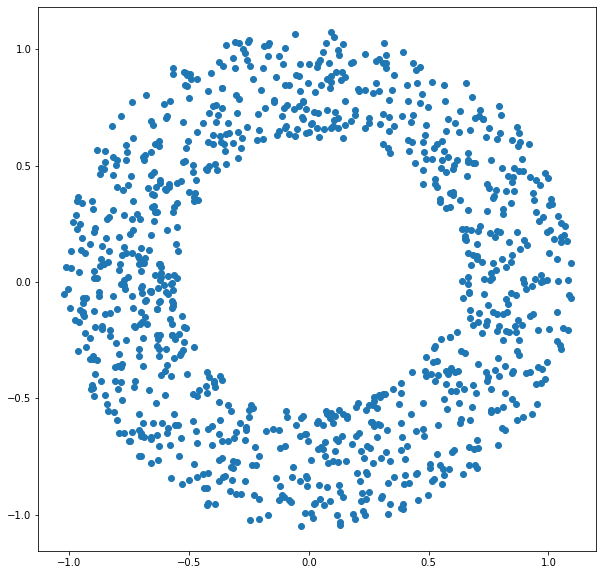

Gamma = 3


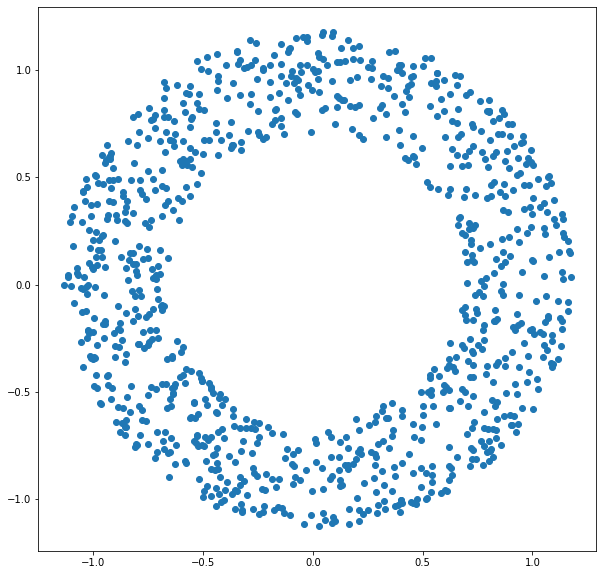

Gamma = 6


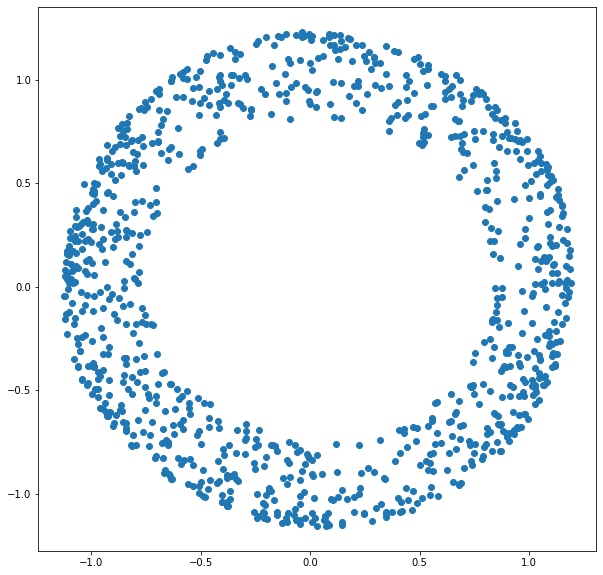

Gamma = 10


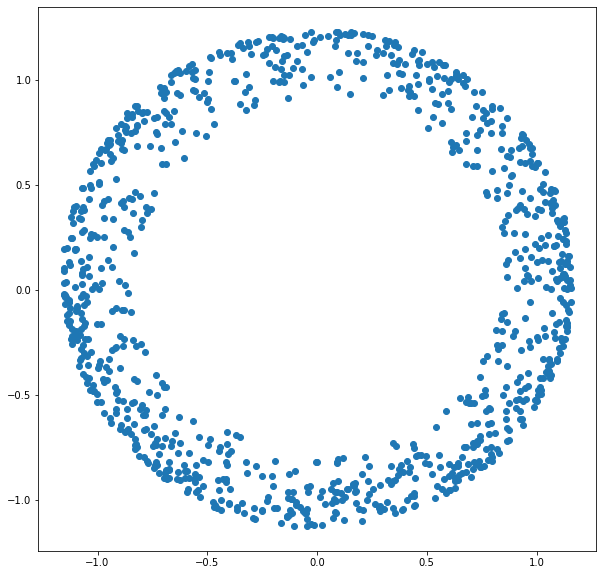

Gamma = 30


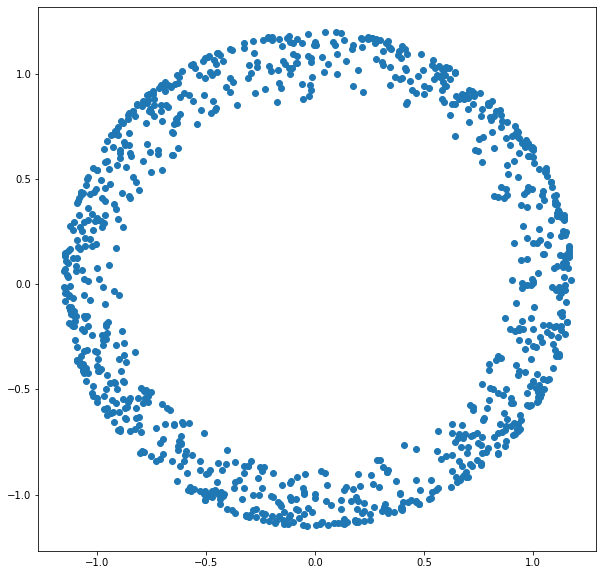

Gamma = 100


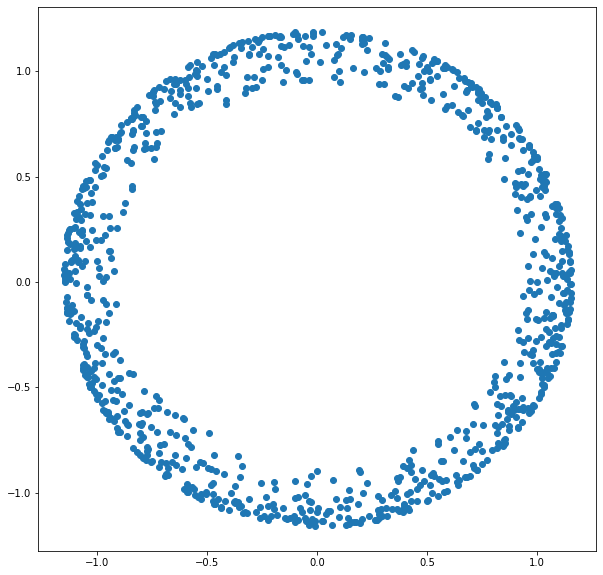

In [5]:
gammas = [0.1, 1, 2, 3, 6, 10, 30, 100]

for gamma in gammas:
    pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

    orig_points = generate_cylinder(1000)
    points = pca.fit_transform(orig_points)

    print('Gamma = {}'.format(gamma))
    
    plt.figure(figsize=(10, 10))

    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

### Now we can calculate the distances

In [6]:
def calc_distance(points_0, points_1):
    pers_0 = ripser.ripser(points_0)
    pers_1 = ripser.ripser(points_1)

    return persim.wasserstein(
        np.concatenate((pers_0['dgms'][0][:-1], pers_0['dgms'][1]), axis=0),
        np.concatenate((pers_1['dgms'][0][:-1], pers_1['dgms'][1]), axis=0)
    )

def calc_distances(gammas, n_points=100):
    results = []
    for gamma in gammas:
        pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)
        
        points_3d = generate_cylinder(n_points)
        points_2d = pca.fit_transform(points_3d)
        
        results.append(calc_distance(points_3d, points_2d))
                       
    return results

In [7]:
distances_list = []
for _ in range(10):
    distances_list.append(calc_distances(gammas, n_points=100))
    
distances = np.array(distances_list)
print(distances)

[[14.11433154 10.18026313  7.30151185  5.77532047  6.28787803  6.45869008
   7.48229056  7.51222048]
 [13.30362457 10.56835127  6.78579347  5.57414029  6.18850158  7.71548969
   7.3189802   8.04105562]
 [13.69035799  9.8283823   5.61580293  6.10056725  6.27797652  7.56999192
   7.2645558   7.24518085]
 [14.31347373 10.56158257  7.25980605  5.84735222  6.67768048  6.01636356
   7.51592438  6.62734947]
 [13.08120402 10.18409635  6.31497773  6.13866756  6.86394716  4.85372901
   6.5801069   8.05657156]
 [13.36543745 10.11375857  6.53401669  6.36048372  5.58327938  6.54476394
   7.35258451  7.75505955]
 [13.68505318  9.72086318  5.56837105  6.15079776  5.62923248  6.97637023
   6.03351012  8.14297428]
 [14.68334373  9.00448944  6.29108753  5.76108416  6.35048349  6.82104486
   7.0425883   8.14633184]
 [13.78133812 10.68076347  7.383301    5.65494161  7.01611128  6.97145522
   7.20157437  7.01316033]
 [13.73135527 10.32300081  6.97368028  5.54209493  5.28719692  6.58114515
   7.76255927  7.

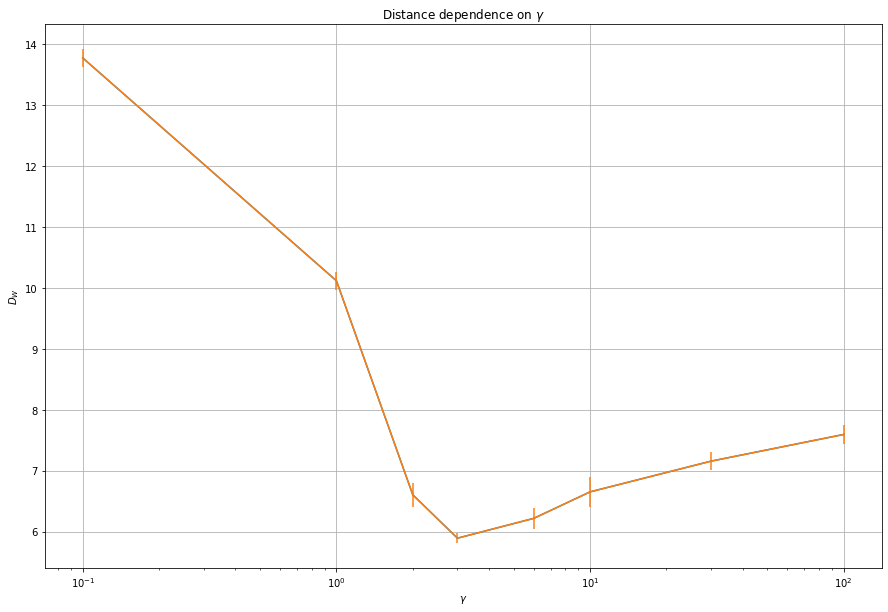

In [8]:
plt.figure(figsize=(15, 10))

plt.semilogx(gammas, distances.mean(axis=0))
plt.errorbar(gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

### We can compare the minimal value with the distance for linear PCA

In [9]:
pca = KernelPCA(2)

distances = []
for _ in range(10):
    points_3d = generate_cylinder(100)
    points_2d = pca.fit_transform(points_3d)
    
    distances.append(calc_distance(points_3d, points_2d))
    
distances = np.array(distances)

print('Linear PCA distance = {} +- {}'.format(distances.mean(), distances.std() / distances.shape[0] ** 0.5))

Linear PCA distance = 9.835434385404296 +- 0.15818041650348735


### Here we will analyse the robustness

In [10]:
new_gammas = np.linspace(2, 6, 20)

print(new_gammas)

distances_list = []
for _ in range(20):
    distances_list.append(calc_distances(new_gammas, n_points=100))
    
distances = np.array(distances_list)

[2.         2.21052632 2.42105263 2.63157895 2.84210526 3.05263158
 3.26315789 3.47368421 3.68421053 3.89473684 4.10526316 4.31578947
 4.52631579 4.73684211 4.94736842 5.15789474 5.36842105 5.57894737
 5.78947368 6.        ]


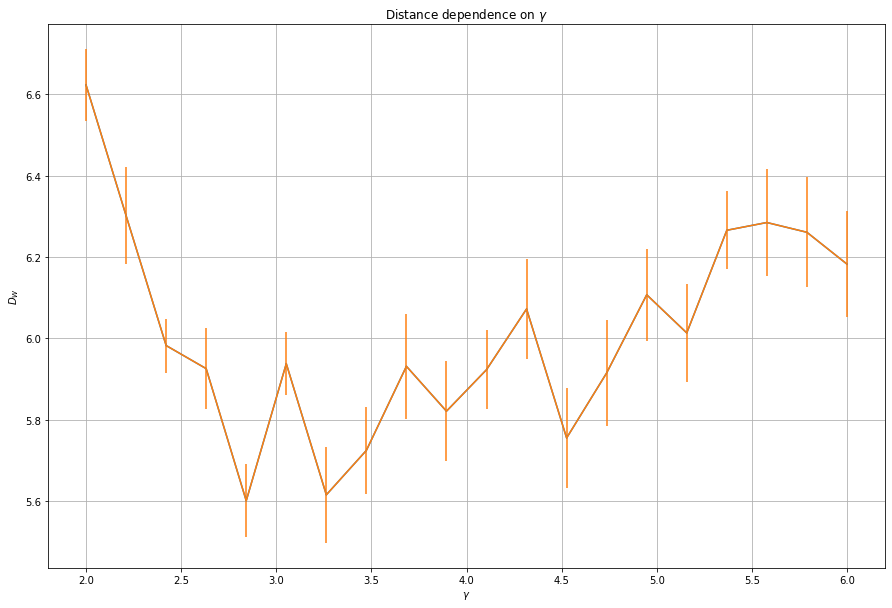

In [11]:
plt.figure(figsize=(15, 10))

plt.plot(new_gammas, distances.mean(axis=0))
plt.errorbar(new_gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

In [12]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

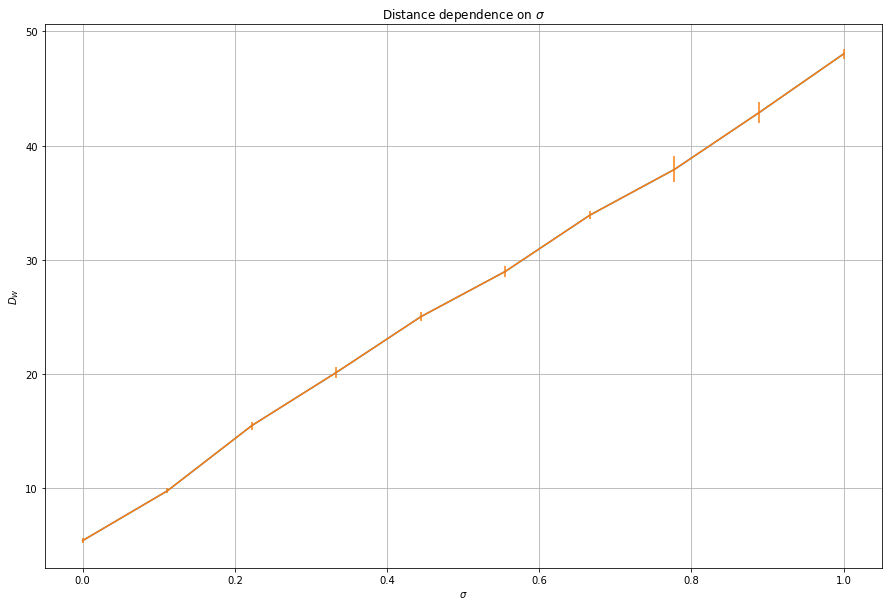

In [13]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

In [14]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 0.1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

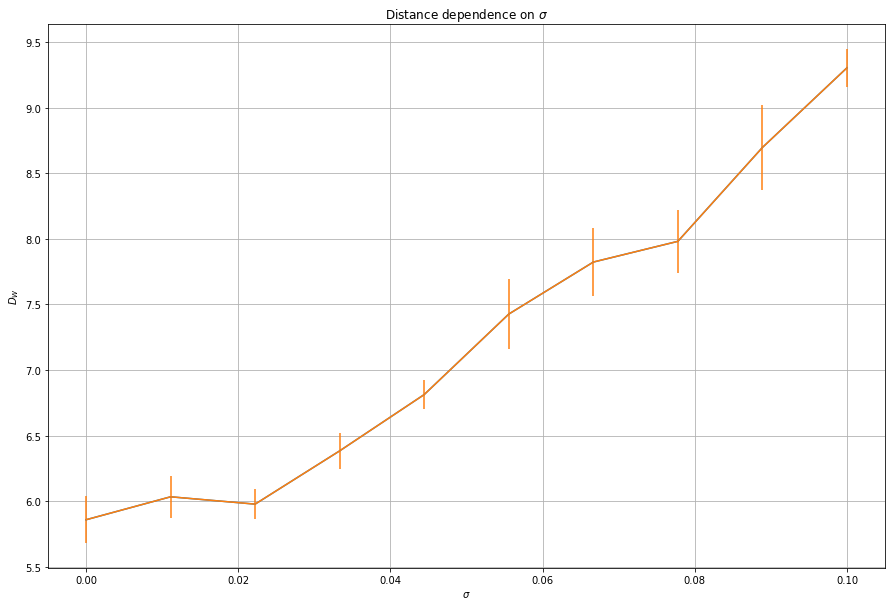

In [15]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 0.1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 0.1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

test


'\nfor i, (label, method) in enumerate(methods.items()):\n    t0 = time()\n    Y = method.fit_transform(X)\n    t1 = time()\n    print("%s: %.2g sec" % (label, t1 - t0))\n    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))\n    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)\n    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))\n    ax.xaxis.set_major_formatter(NullFormatter())\n    ax.yaxis.set_major_formatter(NullFormatter())\n    ax.axis(\'tight\')\n\nplt.show()\n'

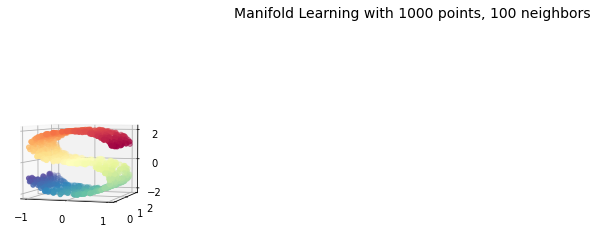

In [13]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 100
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

print("test")

'''
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()
'''

In [32]:
class Centered_Interval:
    def __init__(self, center, interval):
        self.center = center
        self.interval = interval 

    def __str__(self):
        return str([self.center, self.interval])

    def __repr__(self):
        return str(self)

In [38]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets


def method_initialization(n_components, n_neighbors):
    LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

    methods = OrderedDict()
    methods['LLE'] = LLE(method='standard')
    methods['LTSA'] = LLE(method='ltsa')
    methods['Hessian LLE'] = LLE(method='hessian')
    methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                            n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                    random_state=0)
    return methods 

def dataset_initialization(n_points, dataset):
    if (dataset == 'S_curve'):
        X, color = datasets.make_s_curve(n_points, random_state=0)
        return X, color

def upper_round(number):
    if (number % 1 != 0):
        return int(number + 1 - (number%1))
    return int(number)

def lower_round(number):
    return int(number)

def find_center_points(interval, number_of_intervals, base_ring='Integer'):
    if (base_ring == 'Integer'):
        base_left_cor = interval[0]
        int_length = interval[1] - interval[0]
        interval_length = int_length / number_of_intervals
        centered_intervals_list = []
        max_length = 0
        for pos in range(0, number_of_intervals):
            left_corner = lower_round(interval_length * pos + base_left_cor)
            right_corner = upper_round(interval_length * (pos + 1) + base_left_cor)
            interval = [left_corner, right_corner]
            center = lower_round((left_corner + right_corner) / 2)
            centered_interval = Centered_Interval(center, interval)
            centered_intervals_list.append(centered_interval)
            max_length = max(max_length, len(interval))
        return centered_intervals_list, max_length
            
def iterable_object_from_interval(interval, interval_type='k_neighbours'):
    if (interval_type == 'k_neighbours'):
        return range(interval[0], interval[1] + 1)


# Finding sub-optimal parameter for kNN parameter (all methods depends on #k neighbours)
# new_data = method.fit_transform(old_data) - valid for all methods 
# number_of_intervals - число интервалов, на которые делим исходный interval 
# number_suboptimal_intervals - в каждом интервале мы берем середину и смотрим диаграммное расстояние от преобразованных данных до исходных
# этот параметр отвечает за то, сколько параметров рассматриваем в дальнейшем

# Текущая реализация сильно завязана на то, что ищем оптимальный параметр - число соседей (в частности есть завязка на класс Centered_Interval)
def find_optimal_subintervals(interval, method, old_data, 
                                number_suboptimal_intervals = 3, 
                                number_of_intervals = 10,
                                max_length_of_opt_interval = 3):
    if (len(interval) == 1):
        return interval 

    center_points, max_length = find_center_points(interval, number_of_intervals)         # возвращает середины в разбиении интервала interval на #number_of_intervals 
                                                                                          # а так же максимальную длину интервала 

    d_distance_between_data_sets = {}                                                     # key = число ближайших соседей. 
                                                                                          # Value - диаграммное расстояние между old_data & method.fit_transform(old_data)

    if (max_length <= max_length_of_opt_interval):
        distances_list = []                                                               # список списков: distances_list[i] = [kNN, distance_for_k]
                                                                                          # т.е. первое - число соседей для обучения метода, второе - диаграммное расстояние
        for pointed_point in center_points:
            for interval_pt in iterable_object_from_interval(pointed_point.interval):
                if interval_pt not in d_distance_between_data_sets:
                    new_data = method.fit_transform(old_data)
                    distance = calculate_distance(old_data, new_data)
                    d_distance_between_data_sets[interval_pt] = distance 
                distances_list.append([interval_pt, d_distance_between_data_sets[interval_pt]])
        distances_list.sort(key=lambda x: x[1])
        return distances_list[0][0]


    

X, color = dataset_initialization(1000, 'S_curve')

### === START find_center_points TEST === ###
'''
k_values = [1, 100]
result = find_center_points(k_values, 4)
print(result)

k_values = [10, 20]
result = find_center_points(k_values, 12)
print(result)
'''
### === END find_center_points TEST === ###


IndentationError: expected an indented block (<ipython-input-38-d13ece67ce97>, line 79)